# Project AAI Group 6

# MNIST

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
    ])

train_data_mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data_mnist = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_size = int(len(train_data_mnist)*0.85)
val_size = int(len(train_data_mnist)*0.15)
train_set_mnist, val_set_mnist = torch.utils.data.random_split(train_data_mnist, [train_size, val_size])

train_loader_mnist = torch.utils.data.DataLoader(train_set_mnist, batch_size=128, shuffle=True, num_workers=1)
val_loader_mnist = torch.utils.data.DataLoader(val_set_mnist, batch_size=128, shuffle=True, num_workers=1)
test_loader_mnist = torch.utils.data.DataLoader(test_data_mnist, batch_size=128, shuffle=False, num_workers=1)

loaders = {
    'train' : train_loader_mnist,
    'val'   : val_loader_mnist,
    'test'  : test_loader_mnist
}

In [3]:
import torch.nn as nn

class MLP_MNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 500),
            nn.ReLU(),
            nn.Linear(500, 200),
            nn.ReLU(),
            nn.Linear(200, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        return self.layers(x)


class MLP_MNIST_DEEP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 1000),
            nn.ReLU(),
            nn.Linear(1000, 750),
            nn.ReLU(),
            nn.Linear(750, 500),
            nn.ReLU(),
            nn.Linear(500, 250),
            nn.ReLU(),
            nn.Linear(250, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
        )

    def forward(self, x):
        return self.layers(x)

class MLP_MNIST_DEEP_DO(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 1000),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1000, 750),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(750, 500),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(500, 250),
            nn.ReLU(),
            nn.Linear(250, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
        )

    def forward(self, x):
        return self.layers(x)

In [4]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from torch import optim

def train_with_cross_validation(num_epochs, model, dataset, loss_func, optimizer, k_folds=5, batch_size=128):
    kfold = KFold(n_splits=k_folds, shuffle=True)

    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
        # Create data loaders for training and validation
        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_ids))
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(test_ids))

        print(f'FOLD {fold}')
        print('--------------------------------')

        # Training phase
        model.train()
        for epoch in range(num_epochs):
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                output = model(inputs)
                loss = loss_func(output, labels)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if (i + 1) % 100 == 0:
                    print(f'Fold {fold}, Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        # Validation phase
        model.eval()
        with torch.no_grad():
            # Initialize validation loss and accuracy
            val_loss = 0.0
            correct = 0
            total = 0

            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = loss_func(outputs, labels)
                val_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            avg_val_loss = val_loss / len(val_loader)
            accuracy = correct / total

            print(f'Fold {fold}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}')

        print('--------------------------------')

    print('Training process has finished.')
    return model

def train(num_epochs, model, loaders, loss_func, optimizer):
    total_step = len(loaders['train'])
    total_step_val = len(loaders['val'])
    train_loss = []
    val_loss = []
    last_val_loss = 100000
    best_model = model
    
    for epoch in range(num_epochs):
        model.train()
        running_loss_train = 0
        running_loss_val = 0

        #Train model
        for i, data in enumerate(loaders['train']):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            output = model(inputs)
            loss_train = loss_func(output, labels)
            running_loss_train += loss_train.item()

            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}, Step [{i+1}/{total_step}, Loss: {loss_train.item():.4f}]]')

        train_loss.append(running_loss_train / total_step)

        #Gwt loss on evaluation set
        model.eval()
        with torch.no_grad():
            for images, labels in loaders['val']:
                images = images.to(device)
                labels = labels.to(device)

                output = model(images)
                loss_val = loss_func(output, labels)
                running_loss_val += loss_val.item()
        curr_loss = running_loss_val / total_step_val
        val_loss.append(curr_loss)
        #Early stopping
        if curr_loss < last_val_loss:
            best_model = model

    return best_model, train_loss, val_loss

def test(model, loaders):
    accuracies = []
    y_true = []
    y_pred = []

    model.eval()
    with torch.no_grad():
        for images, labels in loaders['test']:
            images = images.to(device)
            labels = labels.to(device)

            test_output = model(images)

            y_pred.extend(test_output.data.cpu().detach().numpy())
            y_true.extend(labels.data.cpu().detach().numpy())

            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            accuracies.append(accuracy)

    total_accuracy = round(sum(accuracies)/len(accuracies), 2)
    print(f'Accuracy: {total_accuracy*100}%')

    y_pred = [x.argmax() for x in y_pred]
    print(classification_report(y_true, y_pred))

    cf_matrix = confusion_matrix(y_true, y_pred)
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    ax = sns.heatmap(cf_matrix/cf_matrix.astype(float).sum(axis=1), annot=True, fmt='.2%')

    return total_accuracy

def plot_acc(train, val, name):
    fig1, ax1 = plt.subplots()
    ax1.plot(train, label='Training loss')
    ax1.plot(val, label='Validation loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'Training and validation loss: {name}')
    plt.legend()
    plt.show()

def train_models(networks, loaders, num_epochs):
    for network in networks:
        model = None
        loss_func = None
        optimizer = None

        model = network
        model.to(device)

        loss_func = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr = 0.001)

        print(f"Training {model.__class__.__name__}")
        best_model = None
        training_loss = None
        val_loss = None
        best_model, training_loss, val_loss = train(num_epochs, model, loaders, loss_func, optimizer)
        _ = test(best_model, loaders)
        plot_acc(training_loss, val_loss, model.__class__.__name__)

## Training with 85/15 training/validation set and early stopping

Training MLP_MNIST
Epoch [1/20, Step [100/399, Loss: 0.3488]]
Epoch [1/20, Step [200/399, Loss: 0.3848]]
Epoch [1/20, Step [300/399, Loss: 0.2509]]
Epoch [2/20, Step [100/399, Loss: 0.1375]]
Epoch [2/20, Step [200/399, Loss: 0.0659]]
Epoch [2/20, Step [300/399, Loss: 0.1251]]
Epoch [3/20, Step [100/399, Loss: 0.1680]]
Epoch [3/20, Step [200/399, Loss: 0.1164]]
Epoch [3/20, Step [300/399, Loss: 0.0710]]
Epoch [4/20, Step [100/399, Loss: 0.0497]]
Epoch [4/20, Step [200/399, Loss: 0.0963]]
Epoch [4/20, Step [300/399, Loss: 0.0707]]
Epoch [5/20, Step [100/399, Loss: 0.0862]]
Epoch [5/20, Step [200/399, Loss: 0.0426]]
Epoch [5/20, Step [300/399, Loss: 0.0499]]
Epoch [6/20, Step [100/399, Loss: 0.0692]]
Epoch [6/20, Step [200/399, Loss: 0.0416]]
Epoch [6/20, Step [300/399, Loss: 0.1615]]
Epoch [7/20, Step [100/399, Loss: 0.0570]]
Epoch [7/20, Step [200/399, Loss: 0.0460]]
Epoch [7/20, Step [300/399, Loss: 0.1320]]
Epoch [8/20, Step [100/399, Loss: 0.0063]]
Epoch [8/20, Step [200/399, Loss: 0

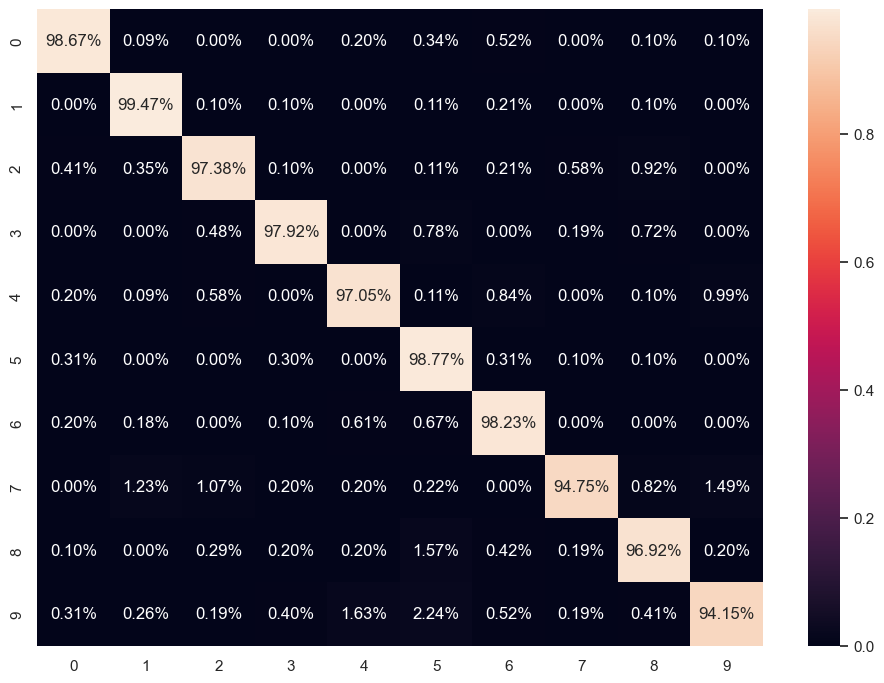

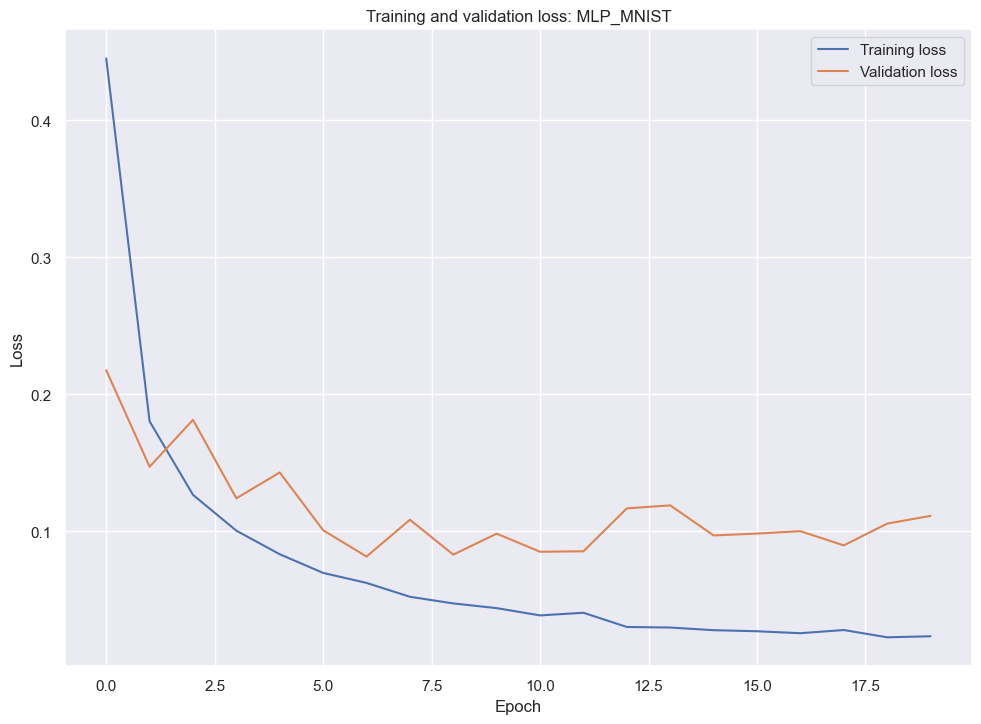

Training MLP_MNIST_DEEP
Epoch [1/20, Step [100/399, Loss: 0.4615]]
Epoch [1/20, Step [200/399, Loss: 0.3273]]
Epoch [1/20, Step [300/399, Loss: 0.1906]]
Epoch [2/20, Step [100/399, Loss: 0.1434]]
Epoch [2/20, Step [200/399, Loss: 0.1446]]
Epoch [2/20, Step [300/399, Loss: 0.0889]]
Epoch [3/20, Step [100/399, Loss: 0.1551]]
Epoch [3/20, Step [200/399, Loss: 0.0998]]
Epoch [3/20, Step [300/399, Loss: 0.1062]]
Epoch [4/20, Step [100/399, Loss: 0.2109]]
Epoch [4/20, Step [200/399, Loss: 0.1662]]
Epoch [4/20, Step [300/399, Loss: 0.0997]]
Epoch [5/20, Step [100/399, Loss: 0.0848]]
Epoch [5/20, Step [200/399, Loss: 0.0225]]
Epoch [5/20, Step [300/399, Loss: 0.0537]]
Epoch [6/20, Step [100/399, Loss: 0.0555]]
Epoch [6/20, Step [200/399, Loss: 0.0493]]
Epoch [6/20, Step [300/399, Loss: 0.0196]]
Epoch [7/20, Step [100/399, Loss: 0.0883]]
Epoch [7/20, Step [200/399, Loss: 0.0684]]
Epoch [7/20, Step [300/399, Loss: 0.0322]]
Epoch [8/20, Step [100/399, Loss: 0.0350]]
Epoch [8/20, Step [200/399, Lo

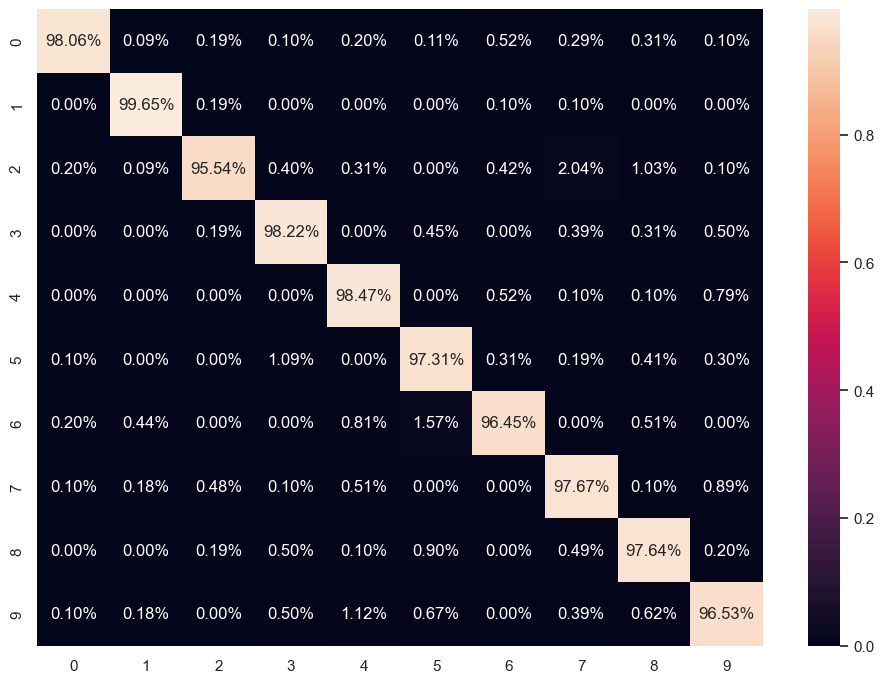

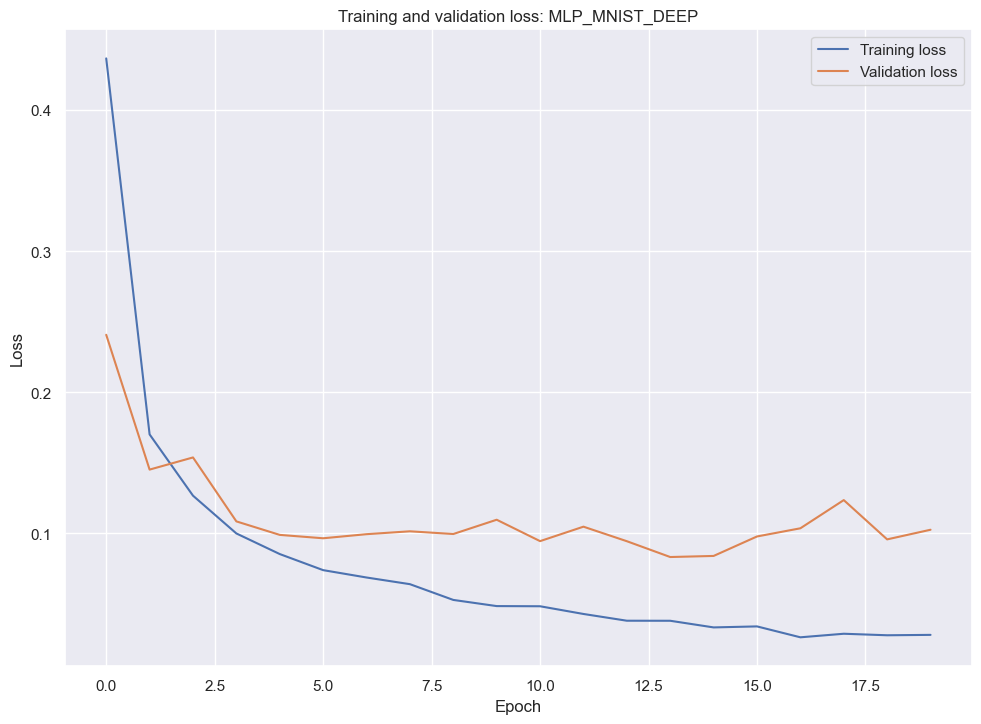

Training MLP_MNIST_DEEP_DO
Epoch [1/20, Step [100/399, Loss: 0.4408]]
Epoch [1/20, Step [200/399, Loss: 0.3467]]
Epoch [1/20, Step [300/399, Loss: 0.3129]]
Epoch [2/20, Step [100/399, Loss: 0.1176]]
Epoch [2/20, Step [200/399, Loss: 0.2327]]
Epoch [2/20, Step [300/399, Loss: 0.1546]]
Epoch [3/20, Step [100/399, Loss: 0.1968]]
Epoch [3/20, Step [200/399, Loss: 0.1486]]
Epoch [3/20, Step [300/399, Loss: 0.0924]]
Epoch [4/20, Step [100/399, Loss: 0.0618]]
Epoch [4/20, Step [200/399, Loss: 0.0683]]
Epoch [4/20, Step [300/399, Loss: 0.1060]]
Epoch [5/20, Step [100/399, Loss: 0.1593]]
Epoch [5/20, Step [200/399, Loss: 0.0274]]
Epoch [5/20, Step [300/399, Loss: 0.0902]]
Epoch [6/20, Step [100/399, Loss: 0.1104]]
Epoch [6/20, Step [200/399, Loss: 0.1155]]
Epoch [6/20, Step [300/399, Loss: 0.0898]]
Epoch [7/20, Step [100/399, Loss: 0.1302]]
Epoch [7/20, Step [200/399, Loss: 0.1078]]
Epoch [7/20, Step [300/399, Loss: 0.0423]]
Epoch [8/20, Step [100/399, Loss: 0.0408]]
Epoch [8/20, Step [200/399,

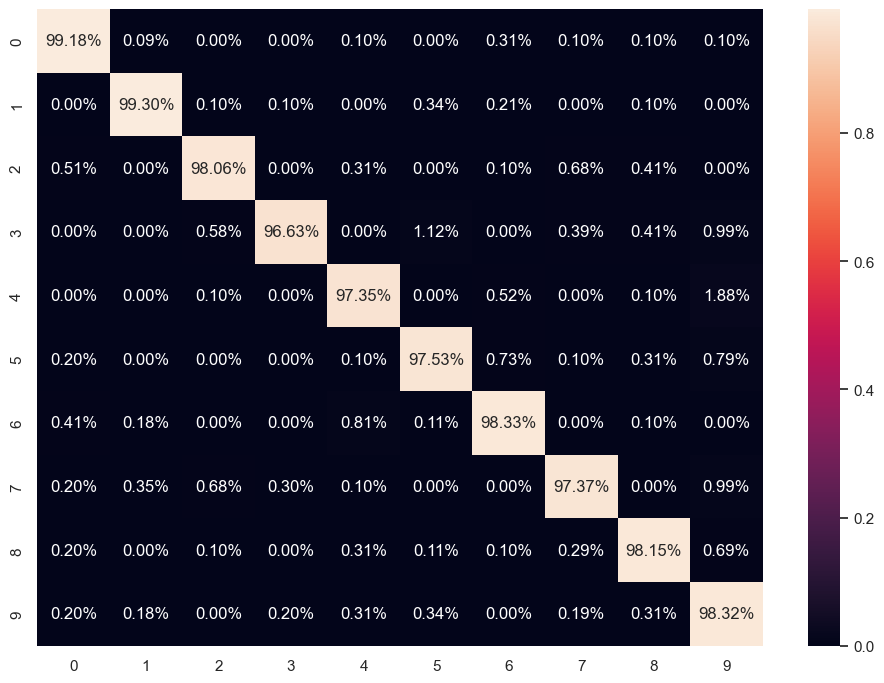

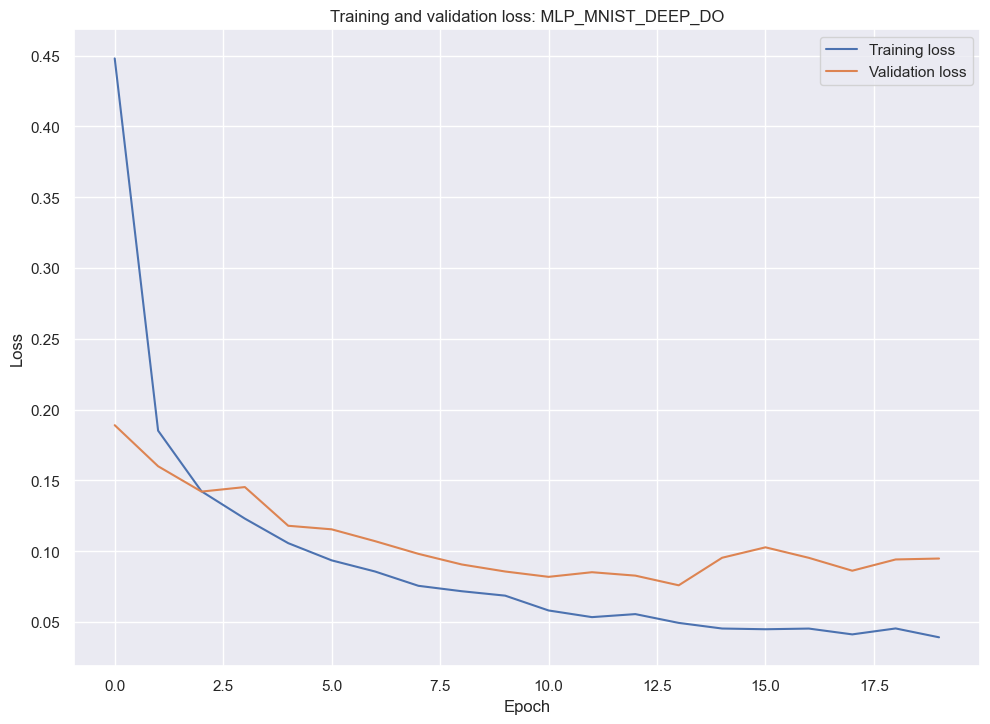

In [5]:
networks = [MLP_MNIST(), MLP_MNIST_DEEP(), MLP_MNIST_DEEP_DO()]

train_models(networks, loaders, 20)

# Training with K-fold cross validation
Training best network architecture from previous runs(MLP_MNIST_DEEP_DO) with 5-fild cross validation

In [5]:
from torch import optim

mlp_mnist = MLP_MNIST_DEEP_DO()
mlp_mnist.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_mnist.parameters(), lr = 0.001)

In [6]:
num_epochs = 20

mlp_mnist = train_with_cross_validation(num_epochs, mlp_mnist, train_data_mnist, loss_func, optimizer)

FOLD 0
--------------------------------
Fold 0, Epoch [1/20], Step [100/375], Loss: 0.3582
Fold 0, Epoch [1/20], Step [200/375], Loss: 0.3862
Fold 0, Epoch [1/20], Step [300/375], Loss: 0.2068
Fold 0, Epoch [2/20], Step [100/375], Loss: 0.2419
Fold 0, Epoch [2/20], Step [200/375], Loss: 0.2748
Fold 0, Epoch [2/20], Step [300/375], Loss: 0.1455
Fold 0, Epoch [3/20], Step [100/375], Loss: 0.2389
Fold 0, Epoch [3/20], Step [200/375], Loss: 0.2295
Fold 0, Epoch [3/20], Step [300/375], Loss: 0.1992
Fold 0, Epoch [4/20], Step [100/375], Loss: 0.1688
Fold 0, Epoch [4/20], Step [200/375], Loss: 0.1155
Fold 0, Epoch [4/20], Step [300/375], Loss: 0.0732
Fold 0, Epoch [5/20], Step [100/375], Loss: 0.1063
Fold 0, Epoch [5/20], Step [200/375], Loss: 0.0812
Fold 0, Epoch [5/20], Step [300/375], Loss: 0.1150
Fold 0, Epoch [6/20], Step [100/375], Loss: 0.1250
Fold 0, Epoch [6/20], Step [200/375], Loss: 0.0748
Fold 0, Epoch [6/20], Step [300/375], Loss: 0.0509
Fold 0, Epoch [7/20], Step [100/375], Loss

Accuracy: 98.0%
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.98      0.99      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.97      0.98       982
           5       0.98      0.99      0.98       892
           6       0.99      0.98      0.98       958
           7       0.97      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



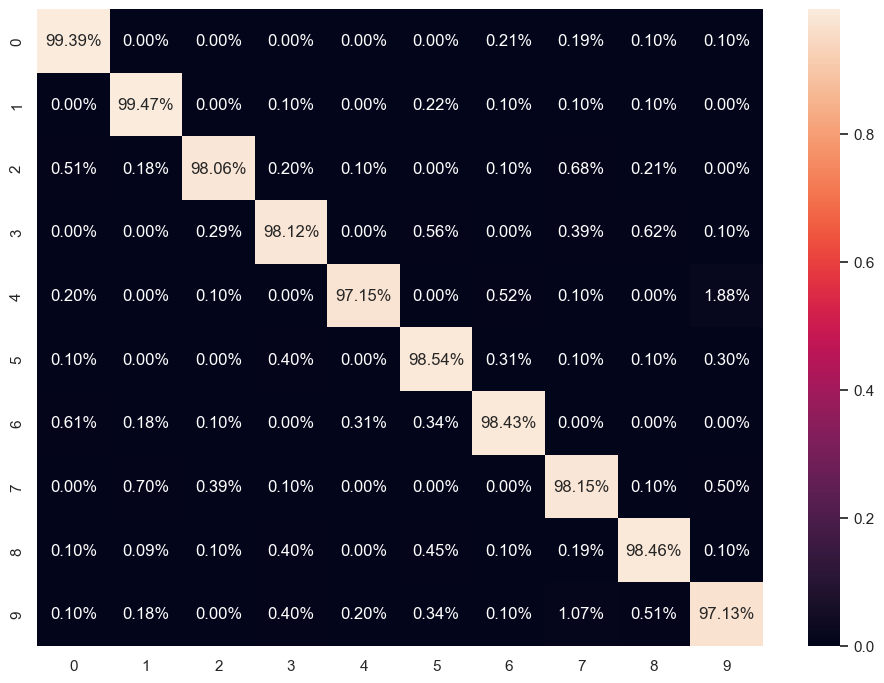

In [7]:
accuracy_mnist = test(mlp_mnist, loaders)

# CNN MNIST

In [8]:
import torch.nn as nn
class CNN_MNIST(nn.Module):
    def __init__(self):
        super(CNN_MNIST, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

class CNN_MNIST_2(nn.Module):
    def __init__(self):
        super(CNN_MNIST_2, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.out = nn.Linear(64 * 3 * 3, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

class CNN_MNIST_2_DO(nn.Module):
    def __init__(self):
        super(CNN_MNIST_2_DO, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),
        )
        self.out = nn.Linear(64 * 3 * 3, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

Training CNN_MNIST
Epoch [1/20, Step [100/399, Loss: 0.2456]]
Epoch [1/20, Step [200/399, Loss: 0.0908]]
Epoch [1/20, Step [300/399, Loss: 0.0296]]
Epoch [2/20, Step [100/399, Loss: 0.0931]]
Epoch [2/20, Step [200/399, Loss: 0.0987]]
Epoch [2/20, Step [300/399, Loss: 0.0917]]
Epoch [3/20, Step [100/399, Loss: 0.0277]]
Epoch [3/20, Step [200/399, Loss: 0.0213]]
Epoch [3/20, Step [300/399, Loss: 0.1179]]
Epoch [4/20, Step [100/399, Loss: 0.0925]]
Epoch [4/20, Step [200/399, Loss: 0.0989]]
Epoch [4/20, Step [300/399, Loss: 0.0515]]
Epoch [5/20, Step [100/399, Loss: 0.0789]]
Epoch [5/20, Step [200/399, Loss: 0.0641]]
Epoch [5/20, Step [300/399, Loss: 0.0203]]
Epoch [6/20, Step [100/399, Loss: 0.0537]]
Epoch [6/20, Step [200/399, Loss: 0.0440]]
Epoch [6/20, Step [300/399, Loss: 0.0315]]
Epoch [7/20, Step [100/399, Loss: 0.0061]]
Epoch [7/20, Step [200/399, Loss: 0.0212]]
Epoch [7/20, Step [300/399, Loss: 0.0028]]
Epoch [8/20, Step [100/399, Loss: 0.0763]]
Epoch [8/20, Step [200/399, Loss: 0

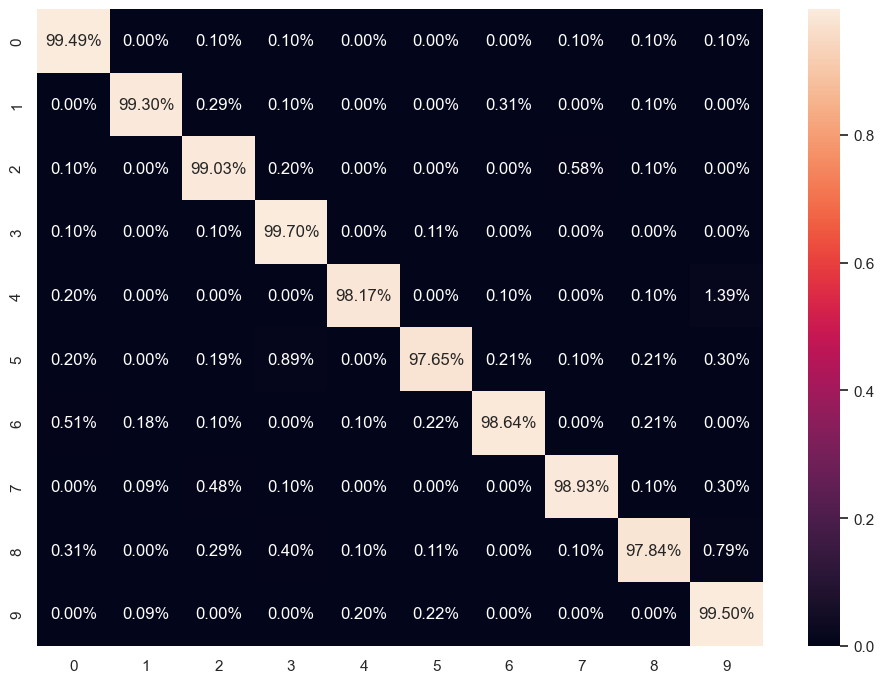

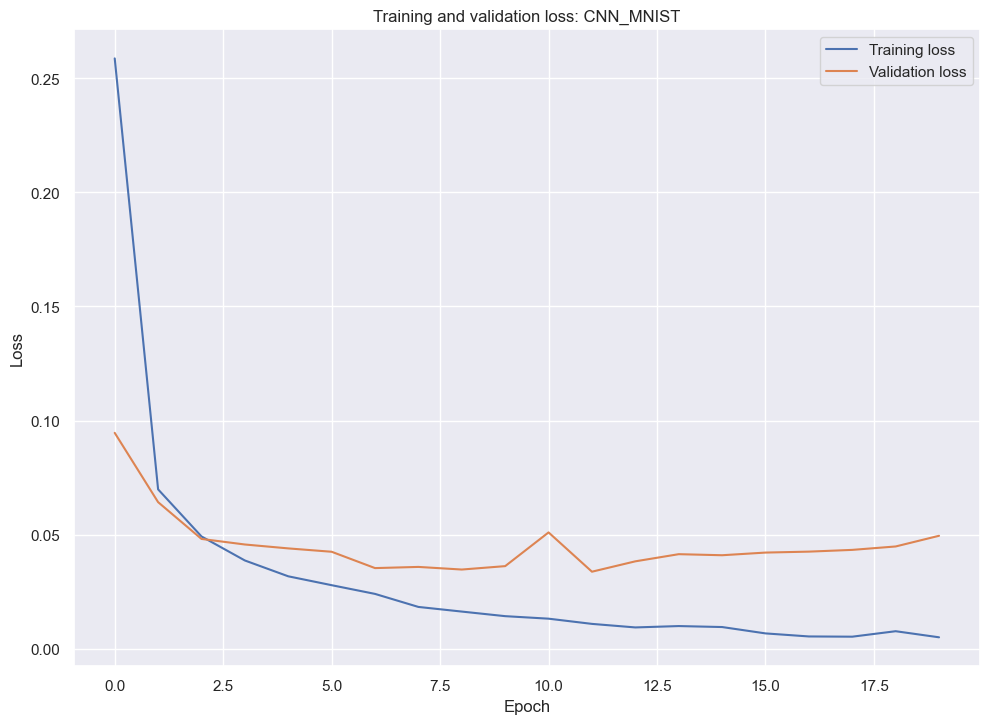

Training CNN_MNIST_2
Epoch [1/20, Step [100/399, Loss: 0.1317]]
Epoch [1/20, Step [200/399, Loss: 0.1242]]
Epoch [1/20, Step [300/399, Loss: 0.0552]]
Epoch [2/20, Step [100/399, Loss: 0.0377]]
Epoch [2/20, Step [200/399, Loss: 0.0710]]
Epoch [2/20, Step [300/399, Loss: 0.0545]]
Epoch [3/20, Step [100/399, Loss: 0.0053]]
Epoch [3/20, Step [200/399, Loss: 0.0541]]
Epoch [3/20, Step [300/399, Loss: 0.0169]]
Epoch [4/20, Step [100/399, Loss: 0.0069]]
Epoch [4/20, Step [200/399, Loss: 0.0403]]
Epoch [4/20, Step [300/399, Loss: 0.0058]]
Epoch [5/20, Step [100/399, Loss: 0.0027]]
Epoch [5/20, Step [200/399, Loss: 0.0432]]
Epoch [5/20, Step [300/399, Loss: 0.0357]]
Epoch [6/20, Step [100/399, Loss: 0.0009]]
Epoch [6/20, Step [200/399, Loss: 0.0141]]
Epoch [6/20, Step [300/399, Loss: 0.0052]]
Epoch [7/20, Step [100/399, Loss: 0.0522]]
Epoch [7/20, Step [200/399, Loss: 0.0047]]
Epoch [7/20, Step [300/399, Loss: 0.0023]]
Epoch [8/20, Step [100/399, Loss: 0.0148]]
Epoch [8/20, Step [200/399, Loss:

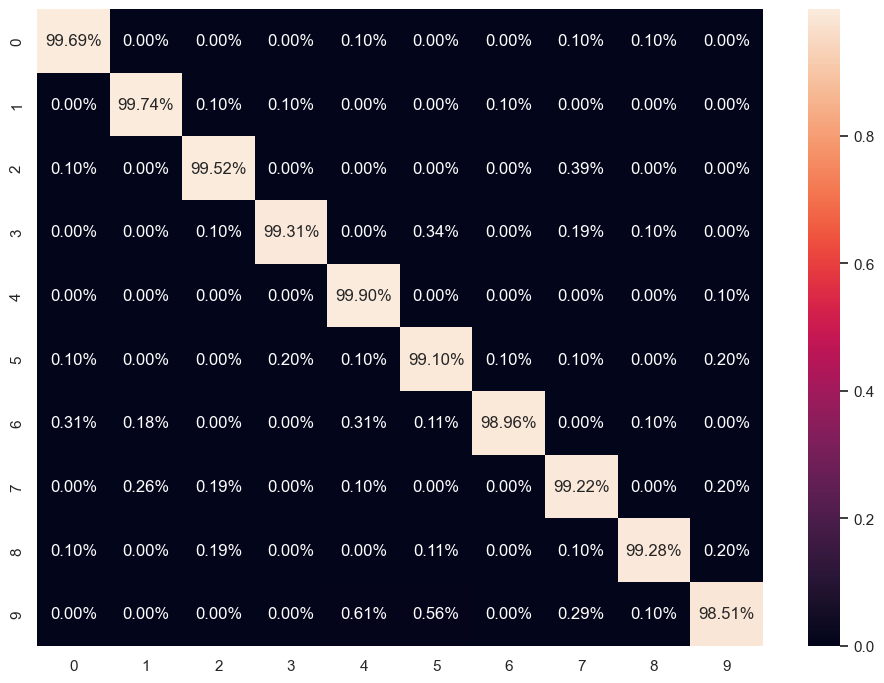

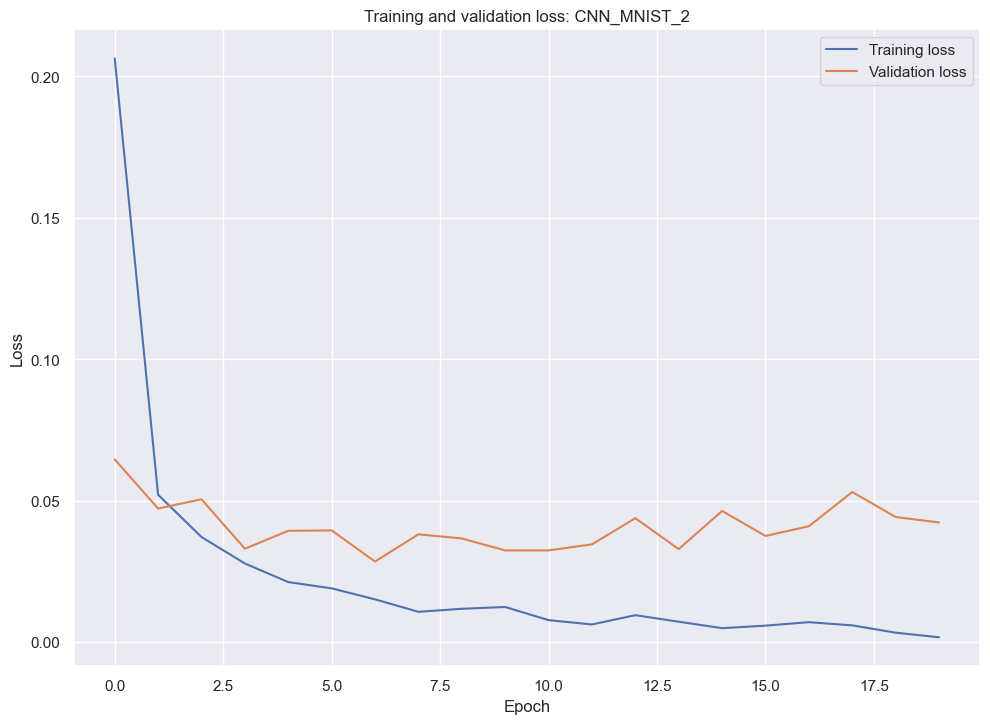

Training CNN_MNIST_2_DO
Epoch [1/20, Step [100/399, Loss: 0.2298]]
Epoch [1/20, Step [200/399, Loss: 0.1523]]
Epoch [1/20, Step [300/399, Loss: 0.1466]]
Epoch [2/20, Step [100/399, Loss: 0.1239]]
Epoch [2/20, Step [200/399, Loss: 0.1102]]
Epoch [2/20, Step [300/399, Loss: 0.0364]]
Epoch [3/20, Step [100/399, Loss: 0.0404]]
Epoch [3/20, Step [200/399, Loss: 0.0492]]
Epoch [3/20, Step [300/399, Loss: 0.0336]]
Epoch [4/20, Step [100/399, Loss: 0.0195]]
Epoch [4/20, Step [200/399, Loss: 0.0596]]
Epoch [4/20, Step [300/399, Loss: 0.1372]]
Epoch [5/20, Step [100/399, Loss: 0.0172]]
Epoch [5/20, Step [200/399, Loss: 0.0555]]
Epoch [5/20, Step [300/399, Loss: 0.0460]]
Epoch [6/20, Step [100/399, Loss: 0.0588]]
Epoch [6/20, Step [200/399, Loss: 0.0115]]
Epoch [6/20, Step [300/399, Loss: 0.0196]]
Epoch [7/20, Step [100/399, Loss: 0.0204]]
Epoch [7/20, Step [200/399, Loss: 0.0089]]
Epoch [7/20, Step [300/399, Loss: 0.0265]]
Epoch [8/20, Step [100/399, Loss: 0.0197]]
Epoch [8/20, Step [200/399, Lo

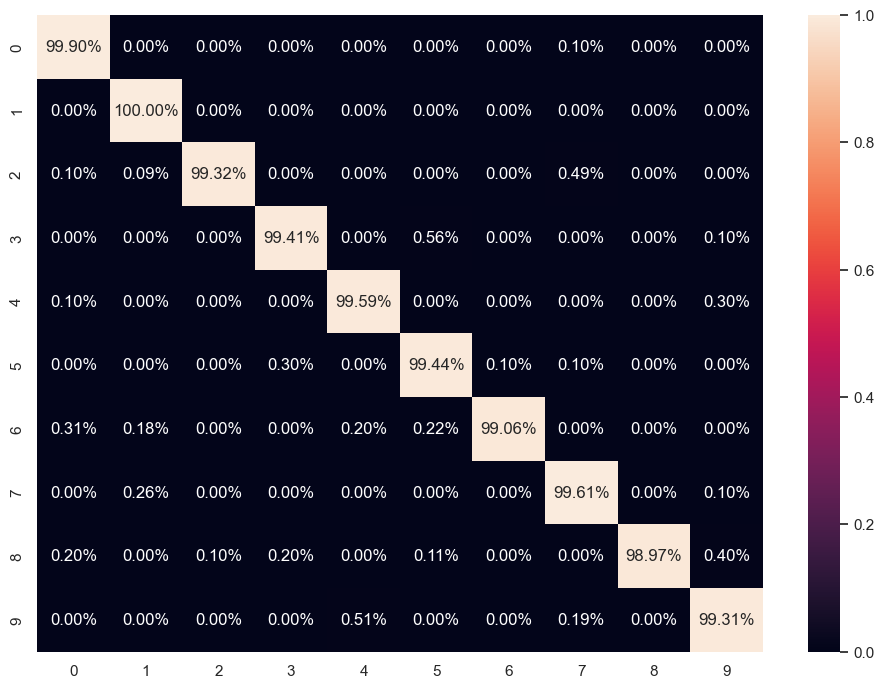

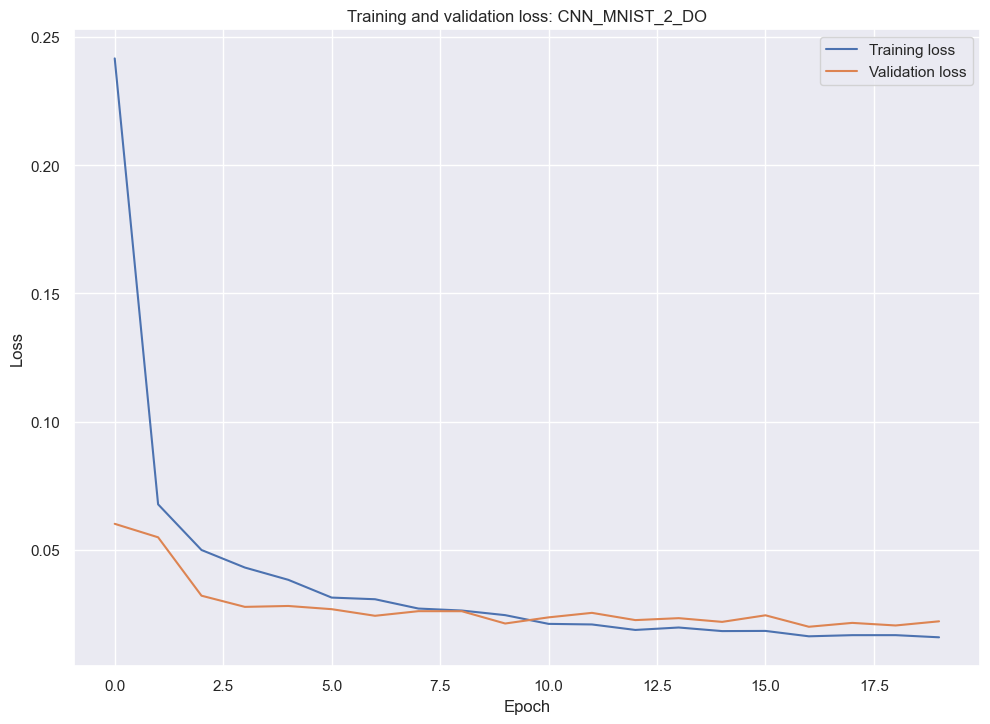

In [10]:
networks = [CNN_MNIST(), CNN_MNIST_2(), CNN_MNIST_2_DO()]

train_models(networks, loaders, 20)

# Training with K-fold cross validation
Training best network architecture from previous runs(CNN_MNIST_2_DO) with 5-fild cross validation

In [11]:
from torch import optim

cnn_mnist = CNN_MNIST_2_DO()
cnn_mnist.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_mnist.parameters(), lr = 0.001)

In [12]:
num_epochs = 20

cnn_mnist = train_with_cross_validation(num_epochs, cnn_mnist, train_data_mnist, loss_func, optimizer)

FOLD 0
--------------------------------
Fold 0, Epoch [1/20], Step [100/375], Loss: 0.1197
Fold 0, Epoch [1/20], Step [200/375], Loss: 0.1155
Fold 0, Epoch [1/20], Step [300/375], Loss: 0.1001
Fold 0, Epoch [2/20], Step [100/375], Loss: 0.1004
Fold 0, Epoch [2/20], Step [200/375], Loss: 0.0349
Fold 0, Epoch [2/20], Step [300/375], Loss: 0.0505
Fold 0, Epoch [3/20], Step [100/375], Loss: 0.0309
Fold 0, Epoch [3/20], Step [200/375], Loss: 0.0417
Fold 0, Epoch [3/20], Step [300/375], Loss: 0.0345
Fold 0, Epoch [4/20], Step [100/375], Loss: 0.0416
Fold 0, Epoch [4/20], Step [200/375], Loss: 0.0121
Fold 0, Epoch [4/20], Step [300/375], Loss: 0.0265
Fold 0, Epoch [5/20], Step [100/375], Loss: 0.0331
Fold 0, Epoch [5/20], Step [200/375], Loss: 0.0418
Fold 0, Epoch [5/20], Step [300/375], Loss: 0.0093
Fold 0, Epoch [6/20], Step [100/375], Loss: 0.0163
Fold 0, Epoch [6/20], Step [200/375], Loss: 0.0077
Fold 0, Epoch [6/20], Step [300/375], Loss: 0.0074
Fold 0, Epoch [7/20], Step [100/375], Loss

Accuracy: 99.0%
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       1.00      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       1.00      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.99      1.00       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



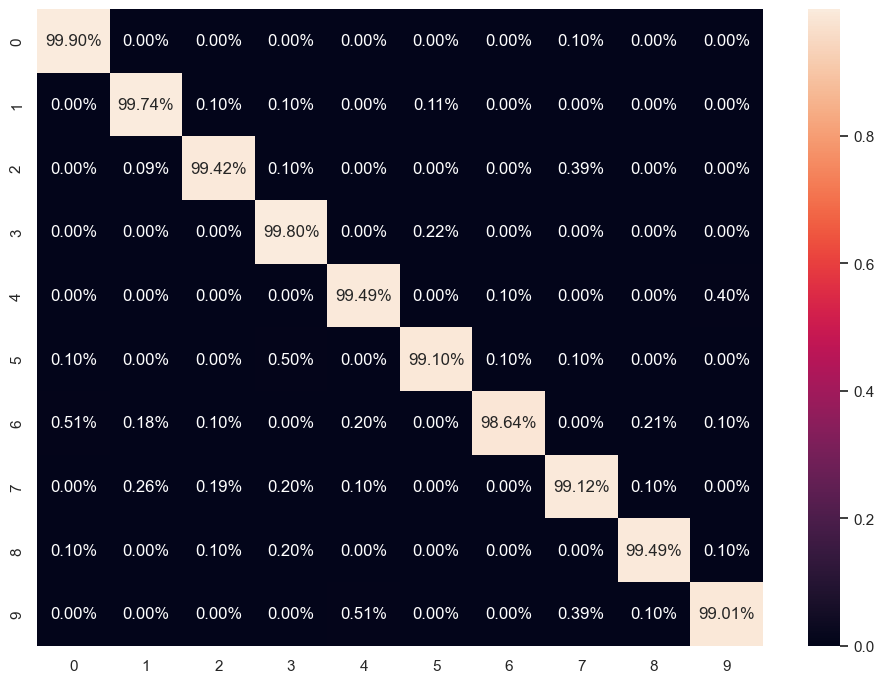

In [13]:
accuracy_mnist_cnn = test(cnn_mnist, loaders)

# MLP CIFAR-10

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [13]:
from torchvision import datasets
import torchvision.transforms as transforms
import torch

transform = transforms.Compose(
    [transforms.Grayscale(num_output_channels=1),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,)),
     #transforms.RandomHorizontalFlip(),
     #transforms.RandomVerticalFlip(),
     #transforms.RandomRotation(30)
    ])

train_data_cifar = datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
test_data_cifar = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_size = int(len(train_data_cifar)*0.85)
val_size = int(len(train_data_cifar)*0.15)
train_set_cifar, val_set_cifar = torch.utils.data.random_split(train_data_cifar, [train_size, val_size])

train_loader_cifar = torch.utils.data.DataLoader(train_set_cifar, batch_size=128, shuffle=True, num_workers=0)
train_loader_cifar_full = torch.utils.data.DataLoader(train_data_cifar, batch_size=128, shuffle=True, num_workers=0)
val_loader_cifar = torch.utils.data.DataLoader(val_set_cifar, batch_size=128, shuffle=True, num_workers=0)
test_loader_cifar = torch.utils.data.DataLoader(test_data_cifar, batch_size=128, shuffle=False, num_workers=0)

loaders = {
    'train': train_loader_cifar,
    'val': val_loader_cifar,
    'test': test_loader_cifar
}

Files already downloaded and verified
Files already downloaded and verified


In [10]:
import torch.nn as nn

class MLP_CIFAR(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32*1, 500),
            nn.ReLU(),
            nn.Linear(500, 200),
            nn.ReLU(),
            nn.Linear(200, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        return self.layers(x)

class MLP_CIFAR_DEEP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32*1, 1000),
            nn.ReLU(),
            nn.Linear(1000, 750),
            nn.ReLU(),
            nn.Linear(750, 500),
            nn.ReLU(),
            nn.Linear(500, 250),
            nn.ReLU(),
            nn.Linear(250, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
        )

    def forward(self, x):
        return self.layers(x)

class MLP_CIFAR_DEEP_DO(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32*1, 1000),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1000, 750),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(750, 500),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(500, 250),
            nn.ReLU(),
            nn.Linear(250, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
        )

    def forward(self, x):
        return self.layers(x)

Training MLP_CIFAR
Epoch [1/20, Step [100/333, Loss: 1.8942]]
Epoch [1/20, Step [200/333, Loss: 1.8810]]
Epoch [1/20, Step [300/333, Loss: 1.6704]]
Epoch [2/20, Step [100/333, Loss: 1.6977]]
Epoch [2/20, Step [200/333, Loss: 1.6943]]
Epoch [2/20, Step [300/333, Loss: 1.7050]]
Epoch [3/20, Step [100/333, Loss: 1.6267]]
Epoch [3/20, Step [200/333, Loss: 1.7329]]
Epoch [3/20, Step [300/333, Loss: 1.5526]]
Epoch [4/20, Step [100/333, Loss: 1.5798]]
Epoch [4/20, Step [200/333, Loss: 1.5622]]
Epoch [4/20, Step [300/333, Loss: 1.5530]]
Epoch [5/20, Step [100/333, Loss: 1.4710]]
Epoch [5/20, Step [200/333, Loss: 1.2987]]
Epoch [5/20, Step [300/333, Loss: 1.3591]]
Epoch [6/20, Step [100/333, Loss: 1.4009]]
Epoch [6/20, Step [200/333, Loss: 1.2471]]
Epoch [6/20, Step [300/333, Loss: 1.3417]]
Epoch [7/20, Step [100/333, Loss: 1.2519]]
Epoch [7/20, Step [200/333, Loss: 1.3392]]
Epoch [7/20, Step [300/333, Loss: 1.2592]]
Epoch [8/20, Step [100/333, Loss: 1.2033]]
Epoch [8/20, Step [200/333, Loss: 1

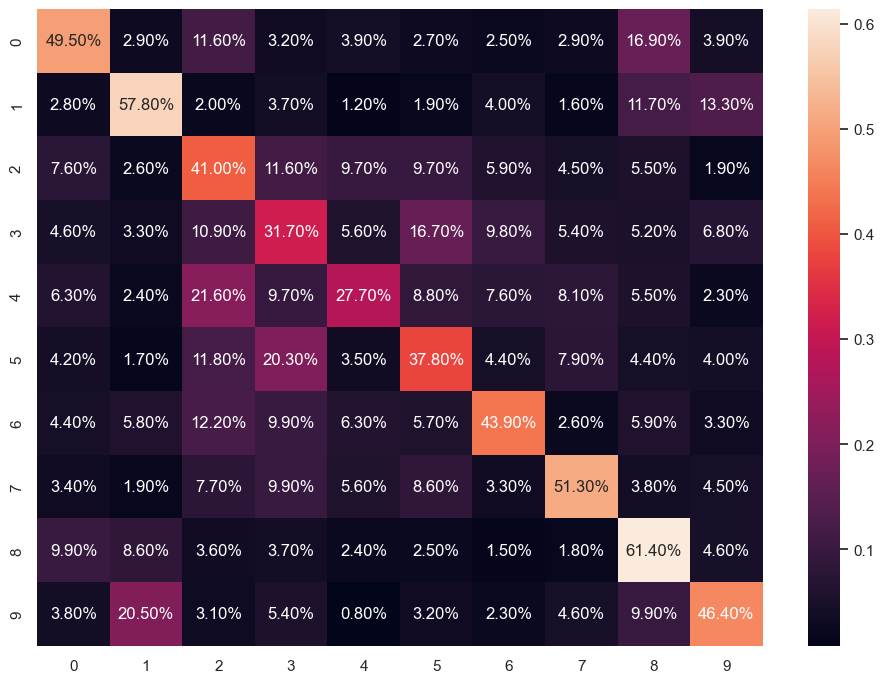

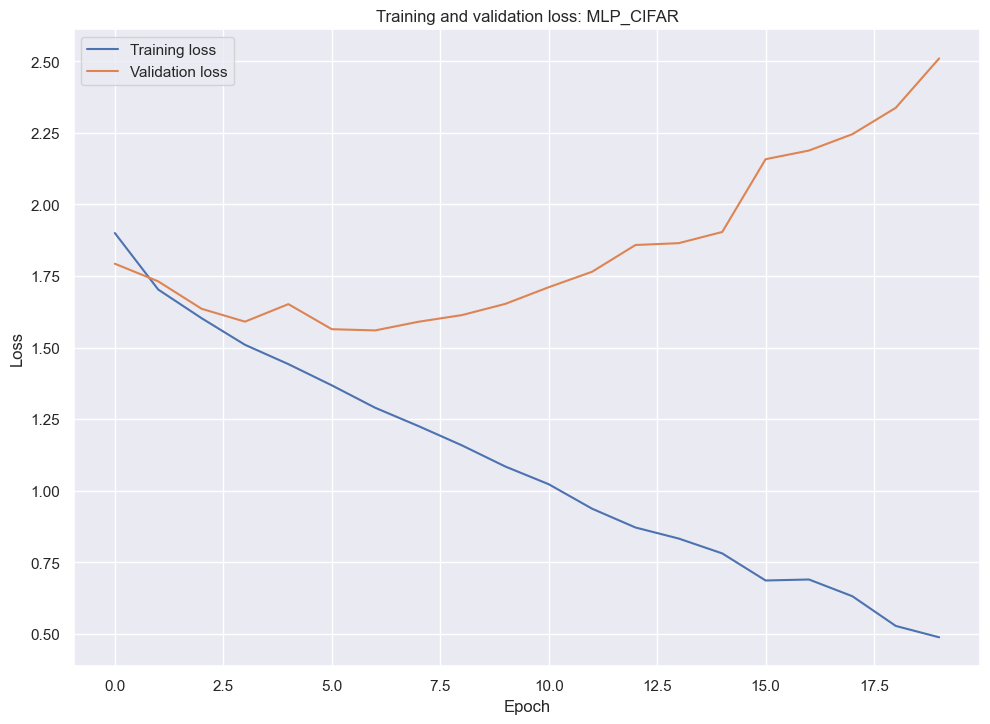

Training MLP_CIFAR_DEEP
Epoch [1/20, Step [100/333, Loss: 2.0426]]
Epoch [1/20, Step [200/333, Loss: 1.9717]]
Epoch [1/20, Step [300/333, Loss: 1.9213]]
Epoch [2/20, Step [100/333, Loss: 1.7430]]
Epoch [2/20, Step [200/333, Loss: 1.7377]]
Epoch [2/20, Step [300/333, Loss: 1.7419]]
Epoch [3/20, Step [100/333, Loss: 1.6497]]
Epoch [3/20, Step [200/333, Loss: 1.5859]]
Epoch [3/20, Step [300/333, Loss: 1.5863]]
Epoch [4/20, Step [100/333, Loss: 1.6168]]
Epoch [4/20, Step [200/333, Loss: 1.6374]]
Epoch [4/20, Step [300/333, Loss: 1.5415]]
Epoch [5/20, Step [100/333, Loss: 1.2608]]
Epoch [5/20, Step [200/333, Loss: 1.4928]]
Epoch [5/20, Step [300/333, Loss: 1.6167]]
Epoch [6/20, Step [100/333, Loss: 1.2534]]
Epoch [6/20, Step [200/333, Loss: 1.3332]]
Epoch [6/20, Step [300/333, Loss: 1.3285]]
Epoch [7/20, Step [100/333, Loss: 1.3746]]
Epoch [7/20, Step [200/333, Loss: 1.1937]]
Epoch [7/20, Step [300/333, Loss: 1.2290]]
Epoch [8/20, Step [100/333, Loss: 1.0803]]
Epoch [8/20, Step [200/333, Lo

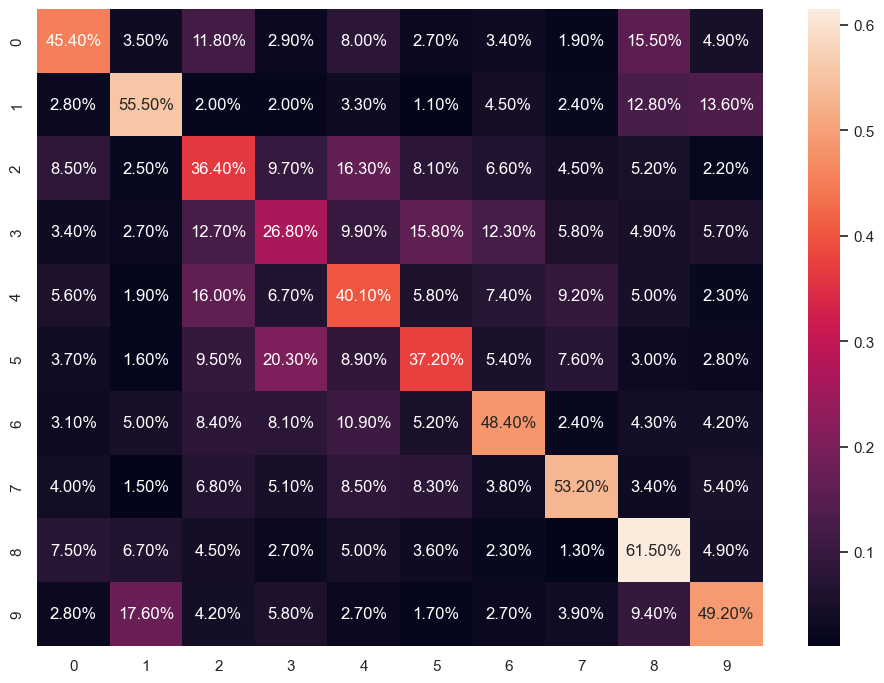

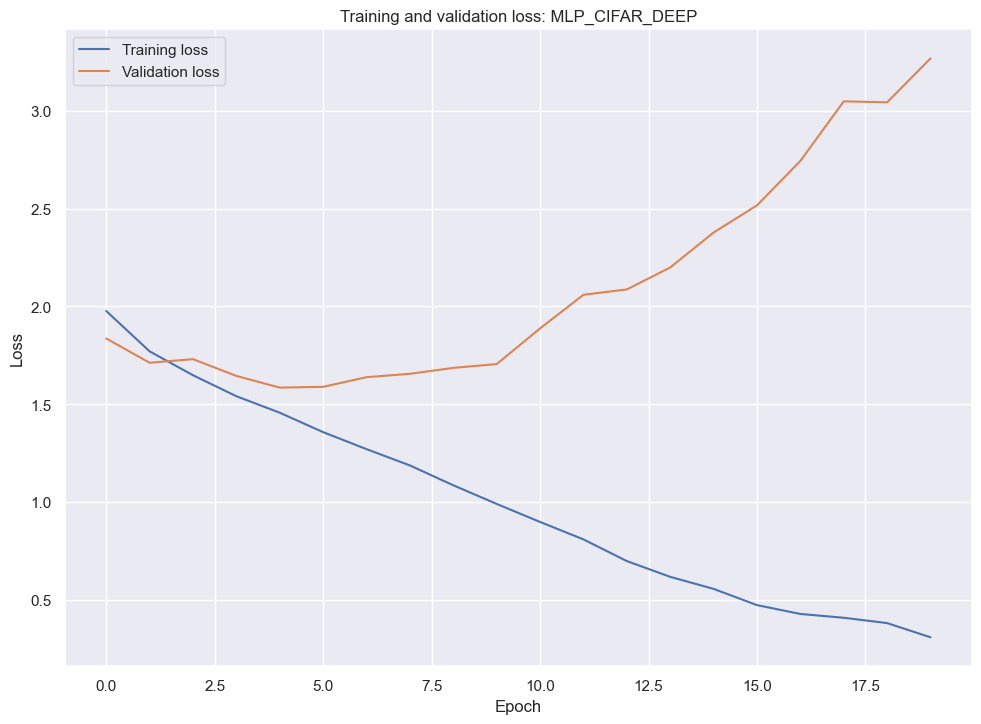

Training MLP_CIFAR_DEEP_DO
Epoch [1/20, Step [100/333, Loss: 2.0046]]
Epoch [1/20, Step [200/333, Loss: 1.9177]]
Epoch [1/20, Step [300/333, Loss: 1.8601]]
Epoch [2/20, Step [100/333, Loss: 1.7790]]
Epoch [2/20, Step [200/333, Loss: 1.7498]]
Epoch [2/20, Step [300/333, Loss: 1.6752]]
Epoch [3/20, Step [100/333, Loss: 1.6584]]
Epoch [3/20, Step [200/333, Loss: 1.7354]]
Epoch [3/20, Step [300/333, Loss: 1.5480]]
Epoch [4/20, Step [100/333, Loss: 1.6378]]
Epoch [4/20, Step [200/333, Loss: 1.7682]]
Epoch [4/20, Step [300/333, Loss: 1.4658]]
Epoch [5/20, Step [100/333, Loss: 1.6342]]
Epoch [5/20, Step [200/333, Loss: 1.4978]]
Epoch [5/20, Step [300/333, Loss: 1.3816]]
Epoch [6/20, Step [100/333, Loss: 1.4505]]
Epoch [6/20, Step [200/333, Loss: 1.4865]]
Epoch [6/20, Step [300/333, Loss: 1.4941]]
Epoch [7/20, Step [100/333, Loss: 1.4996]]
Epoch [7/20, Step [200/333, Loss: 1.4963]]
Epoch [7/20, Step [300/333, Loss: 1.3283]]
Epoch [8/20, Step [100/333, Loss: 1.1678]]
Epoch [8/20, Step [200/333,

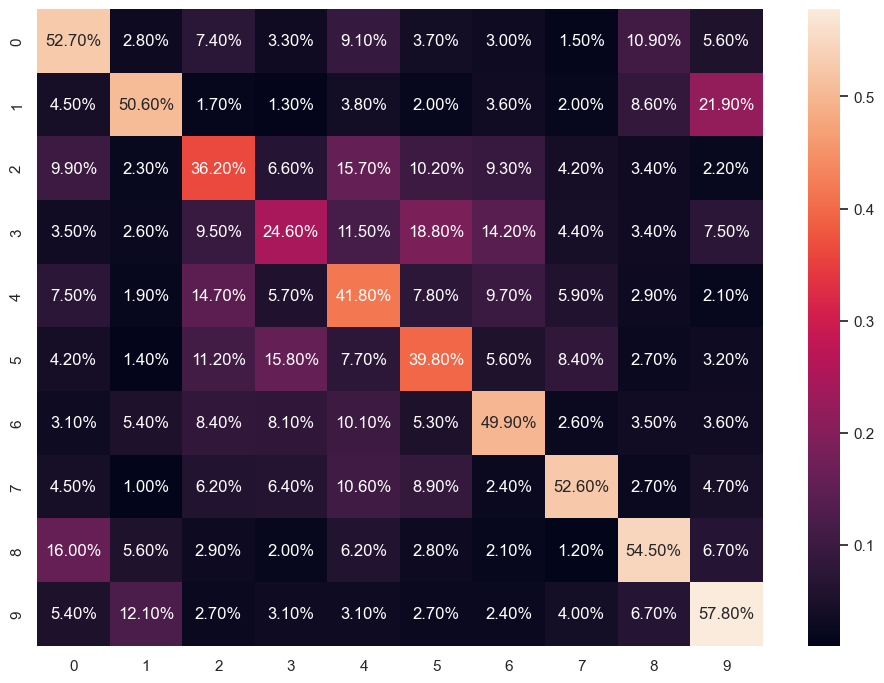

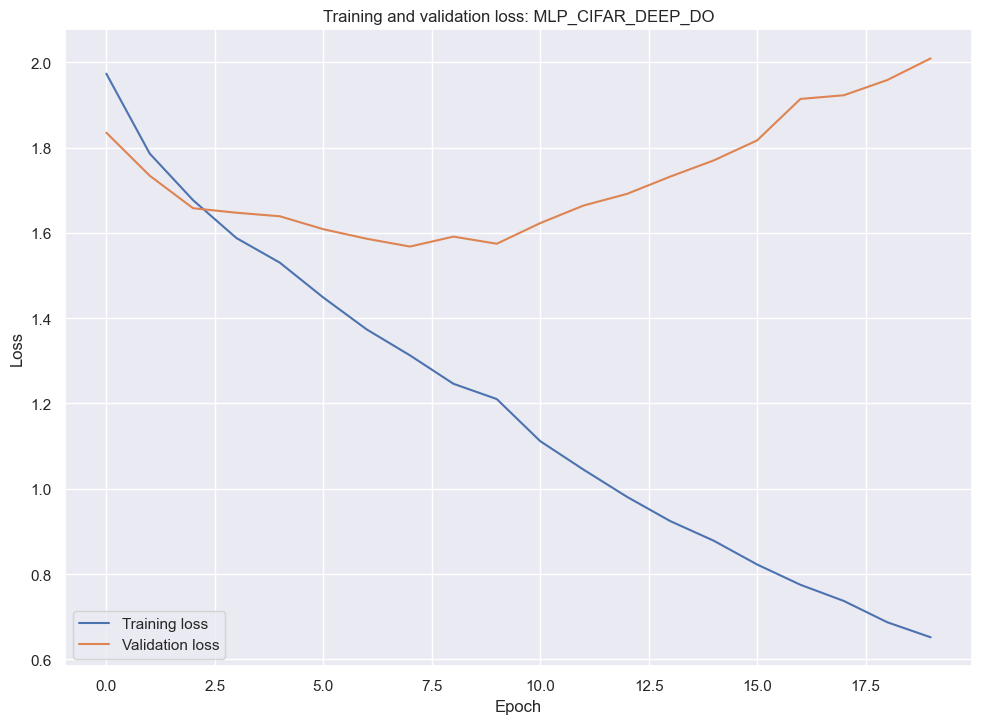

In [17]:
networks = [MLP_CIFAR(), MLP_CIFAR_DEEP(), MLP_CIFAR_DEEP_DO()]

train_models(networks, loaders, 20)

# Training with K-fold cross validation
Training best network architecture from previous runs(MLP_CIFAR_DEEP_DO) with 5-fild cross validation

In [11]:
from torch import optim

mlp_cifar = MLP_CIFAR_DEEP_DO()
mlp_cifar.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_cifar.parameters(), lr = 0.001)

In [14]:
num_epochs = 20

mlp_cifar = train_with_cross_validation(num_epochs, mlp_cifar, train_data_cifar, loss_func, optimizer)

FOLD 0
--------------------------------
Fold 0, Epoch [1/20], Step [100/313], Loss: 1.9927
Fold 0, Epoch [1/20], Step [200/313], Loss: 1.8674
Fold 0, Epoch [1/20], Step [300/313], Loss: 1.8123
Fold 0, Epoch [2/20], Step [100/313], Loss: 1.9100
Fold 0, Epoch [2/20], Step [200/313], Loss: 1.7456
Fold 0, Epoch [2/20], Step [300/313], Loss: 1.6773
Fold 0, Epoch [3/20], Step [100/313], Loss: 1.6719
Fold 0, Epoch [3/20], Step [200/313], Loss: 1.6196
Fold 0, Epoch [3/20], Step [300/313], Loss: 1.8473
Fold 0, Epoch [4/20], Step [100/313], Loss: 1.6302
Fold 0, Epoch [4/20], Step [200/313], Loss: 1.7515
Fold 0, Epoch [4/20], Step [300/313], Loss: 1.6416
Fold 0, Epoch [5/20], Step [100/313], Loss: 1.4503
Fold 0, Epoch [5/20], Step [200/313], Loss: 1.5521
Fold 0, Epoch [5/20], Step [300/313], Loss: 1.4470
Fold 0, Epoch [6/20], Step [100/313], Loss: 1.3461
Fold 0, Epoch [6/20], Step [200/313], Loss: 1.4025
Fold 0, Epoch [6/20], Step [300/313], Loss: 1.4250
Fold 0, Epoch [7/20], Step [100/313], Loss

Accuracy: 47.0%
              precision    recall  f1-score   support

           0       0.53      0.51      0.52      1000
           1       0.64      0.52      0.57      1000
           2       0.39      0.37      0.38      1000
           3       0.29      0.35      0.32      1000
           4       0.38      0.36      0.37      1000
           5       0.41      0.41      0.41      1000
           6       0.49      0.49      0.49      1000
           7       0.60      0.55      0.57      1000
           8       0.57      0.58      0.58      1000
           9       0.50      0.58      0.54      1000

    accuracy                           0.47     10000
   macro avg       0.48      0.47      0.47     10000
weighted avg       0.48      0.47      0.47     10000



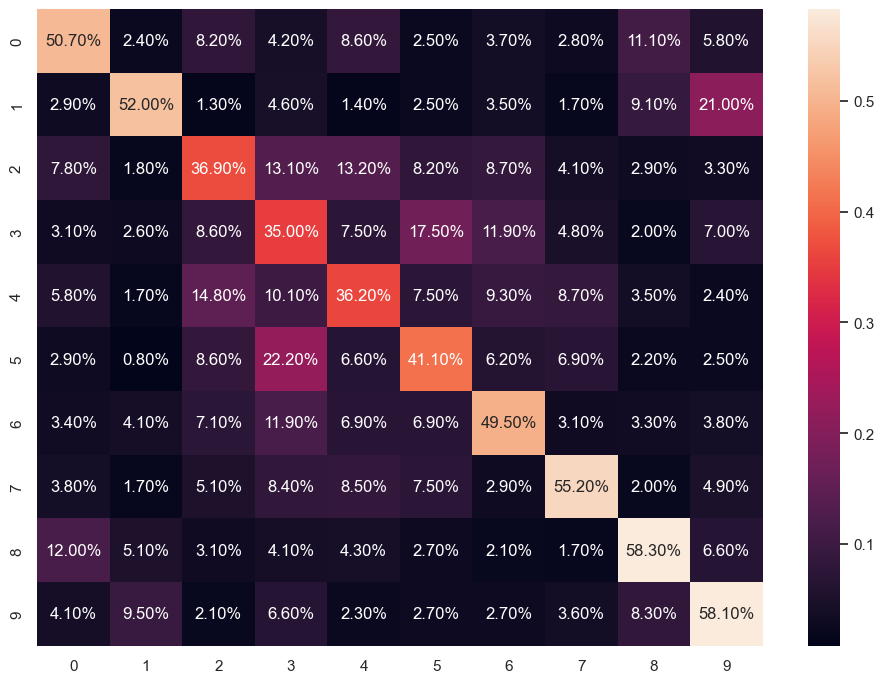

In [15]:
accuracy_cifar_mlp = test(mlp_cifar, loaders)

# CNN CIFAR-10

In [16]:
import torch.nn as nn

import torch.nn as nn
class CNN_CIFAR(nn.Module):
    def __init__(self):
        super(CNN_CIFAR, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.out = nn.Linear(32 * 8 * 8, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

class CNN_CIFAR_2(nn.Module):
    def __init__(self):
        super(CNN_CIFAR_2, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.out = nn.Linear(64 * 4 * 4, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

class CNN_CIFAR_2_DO(nn.Module):
    def __init__(self):
        super(CNN_CIFAR_2_DO, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),
        )
        self.out = nn.Linear(64 * 4 * 4, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output


Training CNN_CIFAR
Epoch [1/20, Step [100/333, Loss: 1.6376]]
Epoch [1/20, Step [200/333, Loss: 1.5700]]
Epoch [1/20, Step [300/333, Loss: 1.6222]]
Epoch [2/20, Step [100/333, Loss: 1.2088]]
Epoch [2/20, Step [200/333, Loss: 1.3109]]
Epoch [2/20, Step [300/333, Loss: 1.3207]]
Epoch [3/20, Step [100/333, Loss: 1.1854]]
Epoch [3/20, Step [200/333, Loss: 1.0680]]
Epoch [3/20, Step [300/333, Loss: 1.1108]]
Epoch [4/20, Step [100/333, Loss: 1.1536]]
Epoch [4/20, Step [200/333, Loss: 1.0656]]
Epoch [4/20, Step [300/333, Loss: 1.1286]]
Epoch [5/20, Step [100/333, Loss: 1.2356]]
Epoch [5/20, Step [200/333, Loss: 1.0225]]
Epoch [5/20, Step [300/333, Loss: 0.9100]]
Epoch [6/20, Step [100/333, Loss: 0.9205]]
Epoch [6/20, Step [200/333, Loss: 0.8248]]
Epoch [6/20, Step [300/333, Loss: 0.9352]]
Epoch [7/20, Step [100/333, Loss: 0.8594]]
Epoch [7/20, Step [200/333, Loss: 0.9323]]
Epoch [7/20, Step [300/333, Loss: 0.8760]]
Epoch [8/20, Step [100/333, Loss: 0.7145]]
Epoch [8/20, Step [200/333, Loss: 0

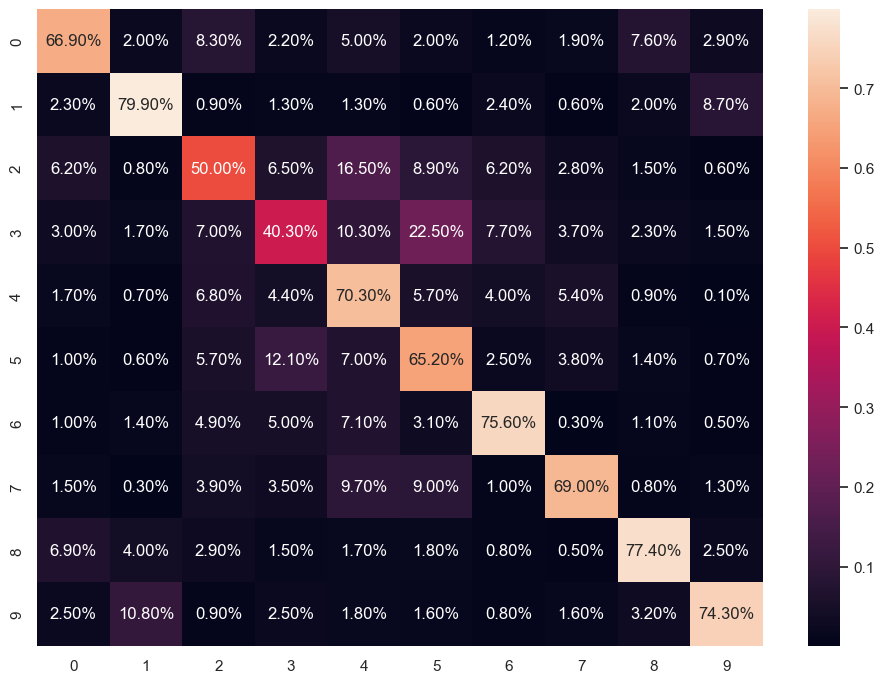

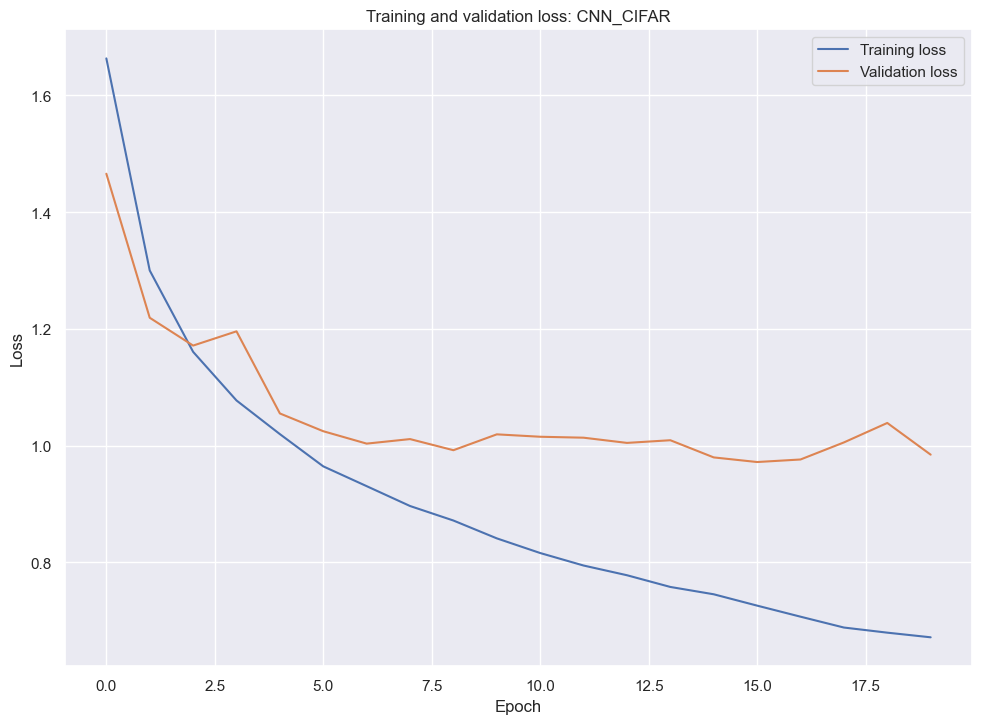

Training CNN_CIFAR_2
Epoch [1/20, Step [100/333, Loss: 1.7978]]
Epoch [1/20, Step [200/333, Loss: 1.5321]]
Epoch [1/20, Step [300/333, Loss: 1.3852]]
Epoch [2/20, Step [100/333, Loss: 1.4362]]
Epoch [2/20, Step [200/333, Loss: 1.2697]]
Epoch [2/20, Step [300/333, Loss: 1.3240]]
Epoch [3/20, Step [100/333, Loss: 1.1972]]
Epoch [3/20, Step [200/333, Loss: 1.3684]]
Epoch [3/20, Step [300/333, Loss: 1.1884]]
Epoch [4/20, Step [100/333, Loss: 1.0377]]
Epoch [4/20, Step [200/333, Loss: 0.9905]]
Epoch [4/20, Step [300/333, Loss: 1.1400]]
Epoch [5/20, Step [100/333, Loss: 0.9482]]
Epoch [5/20, Step [200/333, Loss: 0.9688]]
Epoch [5/20, Step [300/333, Loss: 0.8966]]
Epoch [6/20, Step [100/333, Loss: 1.0418]]
Epoch [6/20, Step [200/333, Loss: 1.0225]]
Epoch [6/20, Step [300/333, Loss: 1.1423]]
Epoch [7/20, Step [100/333, Loss: 0.9131]]
Epoch [7/20, Step [200/333, Loss: 0.8795]]
Epoch [7/20, Step [300/333, Loss: 1.0797]]
Epoch [8/20, Step [100/333, Loss: 0.7633]]
Epoch [8/20, Step [200/333, Loss:

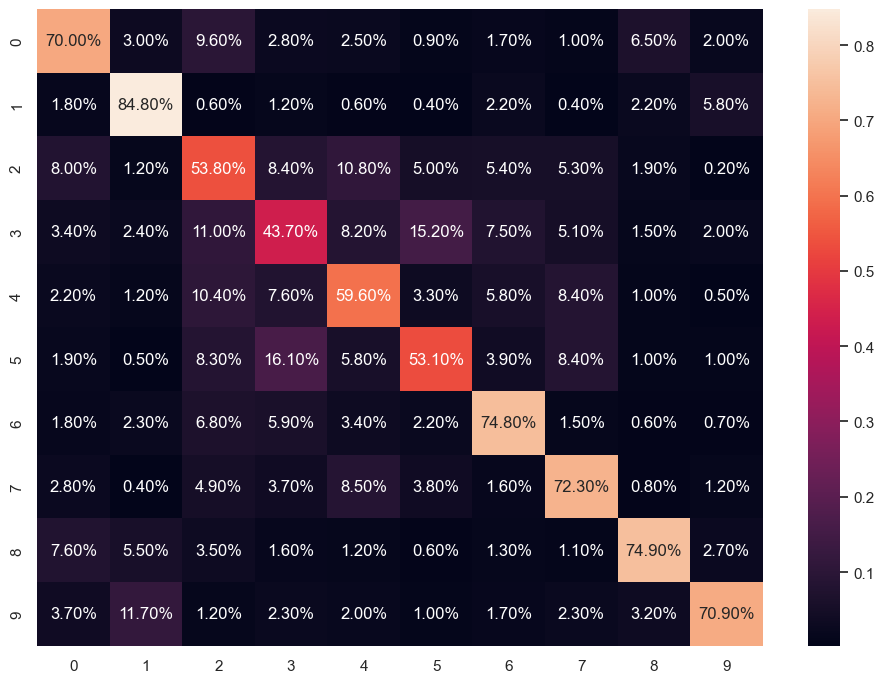

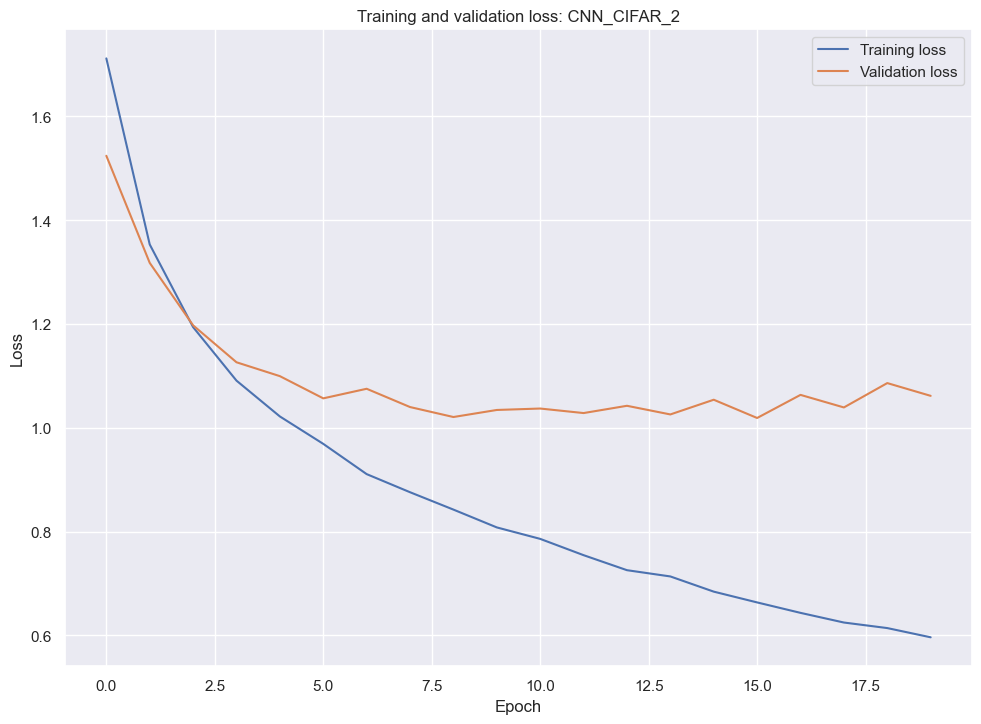

Training CNN_CIFAR_2_DO
Epoch [1/20, Step [100/333, Loss: 1.8383]]
Epoch [1/20, Step [200/333, Loss: 1.6475]]
Epoch [1/20, Step [300/333, Loss: 1.6901]]
Epoch [2/20, Step [100/333, Loss: 1.5339]]
Epoch [2/20, Step [200/333, Loss: 1.5393]]
Epoch [2/20, Step [300/333, Loss: 1.1422]]
Epoch [3/20, Step [100/333, Loss: 1.3401]]
Epoch [3/20, Step [200/333, Loss: 1.4037]]
Epoch [3/20, Step [300/333, Loss: 1.2881]]
Epoch [4/20, Step [100/333, Loss: 1.1004]]
Epoch [4/20, Step [200/333, Loss: 1.3083]]
Epoch [4/20, Step [300/333, Loss: 1.1390]]
Epoch [5/20, Step [100/333, Loss: 1.2138]]
Epoch [5/20, Step [200/333, Loss: 1.1317]]
Epoch [5/20, Step [300/333, Loss: 1.0408]]
Epoch [6/20, Step [100/333, Loss: 1.0474]]
Epoch [6/20, Step [200/333, Loss: 1.1197]]
Epoch [6/20, Step [300/333, Loss: 1.0053]]
Epoch [7/20, Step [100/333, Loss: 1.0691]]
Epoch [7/20, Step [200/333, Loss: 0.8069]]
Epoch [7/20, Step [300/333, Loss: 1.0686]]
Epoch [8/20, Step [100/333, Loss: 1.0374]]
Epoch [8/20, Step [200/333, Lo

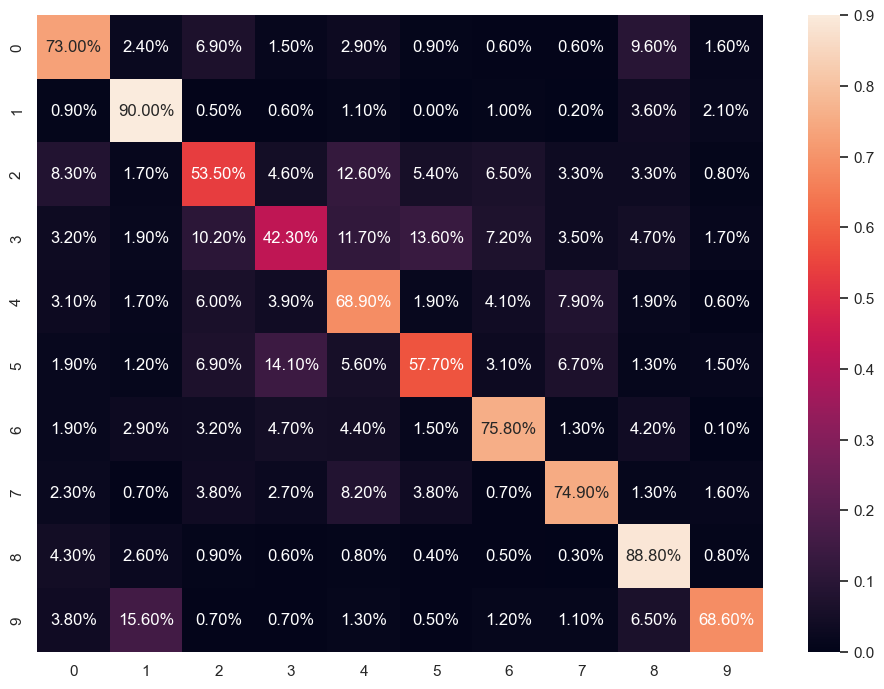

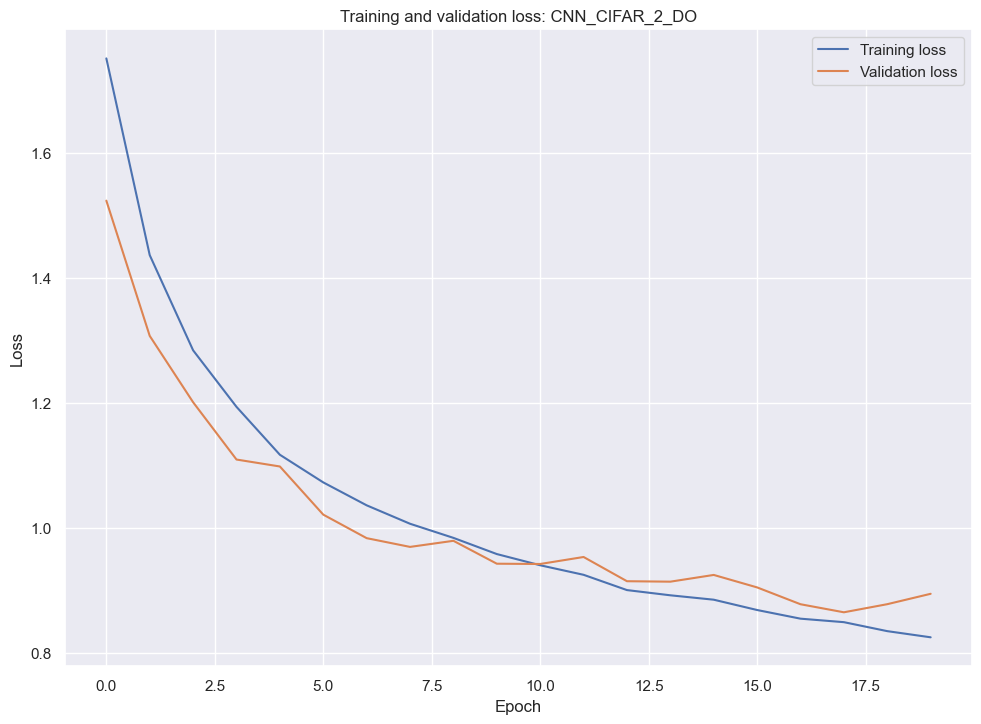

In [22]:
networks = [CNN_CIFAR(), CNN_CIFAR_2(), CNN_CIFAR_2_DO()]

train_models(networks, loaders, 20)

# Training with K-fold cross validation
Training best network architecture from previous runs(CNN_CIFAR_2_DO) with 5-fild cross validation

In [23]:
from torch import optim

cnn_cifar = CNN_CIFAR_2_DO()
cnn_cifar.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_cifar.parameters(), lr = 0.001)

In [24]:
num_epochs = 20

cnn_cifar = train_with_cross_validation(num_epochs, cnn_cifar, train_data_cifar, loss_func, optimizer)

FOLD 0
--------------------------------
Fold 0, Epoch [1/20], Step [100/313], Loss: 1.9758
Fold 0, Epoch [1/20], Step [200/313], Loss: 1.7563
Fold 0, Epoch [1/20], Step [300/313], Loss: 1.6523
Fold 0, Epoch [2/20], Step [100/313], Loss: 1.4127
Fold 0, Epoch [2/20], Step [200/313], Loss: 1.3151
Fold 0, Epoch [2/20], Step [300/313], Loss: 1.3710
Fold 0, Epoch [3/20], Step [100/313], Loss: 1.3040
Fold 0, Epoch [3/20], Step [200/313], Loss: 1.2284
Fold 0, Epoch [3/20], Step [300/313], Loss: 1.3246
Fold 0, Epoch [4/20], Step [100/313], Loss: 1.0726
Fold 0, Epoch [4/20], Step [200/313], Loss: 1.1833
Fold 0, Epoch [4/20], Step [300/313], Loss: 1.0638
Fold 0, Epoch [5/20], Step [100/313], Loss: 1.2586
Fold 0, Epoch [5/20], Step [200/313], Loss: 1.0963
Fold 0, Epoch [5/20], Step [300/313], Loss: 1.2548
Fold 0, Epoch [6/20], Step [100/313], Loss: 1.1421
Fold 0, Epoch [6/20], Step [200/313], Loss: 0.9524
Fold 0, Epoch [6/20], Step [300/313], Loss: 1.0273
Fold 0, Epoch [7/20], Step [100/313], Loss

Accuracy: 73.0%
              precision    recall  f1-score   support

           0       0.74      0.77      0.75      1000
           1       0.90      0.84      0.87      1000
           2       0.69      0.56      0.62      1000
           3       0.57      0.52      0.54      1000
           4       0.67      0.70      0.69      1000
           5       0.66      0.63      0.65      1000
           6       0.76      0.79      0.78      1000
           7       0.78      0.78      0.78      1000
           8       0.76      0.87      0.81      1000
           9       0.77      0.88      0.82      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000



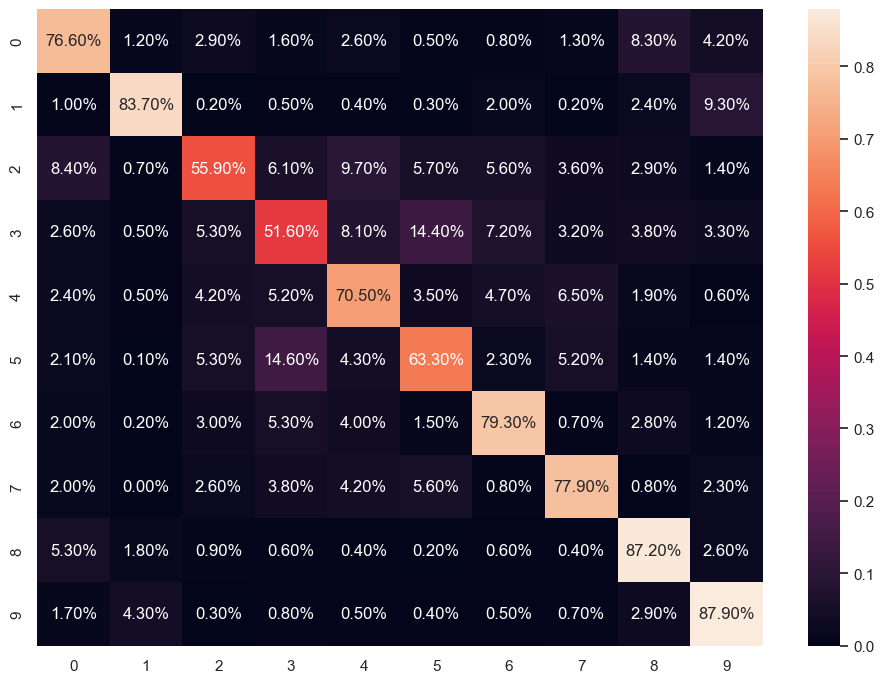

In [25]:
accuracy_cifar_cnn = test(cnn_cifar, loaders)

### Summary

From the results it's quite clear that CNNs are better than MLPs for image classification, which in turn are slightly better than random forests in mnist and comparable on cifar-10. MLPs are similar to decision trees in that they do not take the spatial structure of the data into consideration and will therefore struggle to find meaningful patterns in more complex images. The main advantade of CNNs compared to MLPs is that they do take spatial relationships into consideration by using the values in the convolution kernels as tunable parameters to extract features. As the MLP has the ability to learn more complex patterns in higher dimensionality data compared to decision trees it will be able to perform a bit better on simpler image datasets like mnist, but this will also lead to overfitting in images with more complex features like in cifar-10.

As for network structures, the simple structure we tested is quite comparable to the slightly deeper strucure in terms of accuracy and f1-score when using early stopping, but it's quite clear from looking at the testing and validation plots that the deeper network is ovefitting a bit more, especially for the MLPs on mnist. This is mitigated in the last network type by applying regularization through dropout, which leads to the models generalizing better.